### Importing Necessary Packages

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


### Importing Data

In [87]:
sample_submission = pd.read_csv('data/dogs/sample_submission.csv')
labels = pd.read_csv('data/dogs/labels.csv')
labels = labels[:5000]

### Initial Analysis

In [88]:
print(f"The dataset has {len(labels)} images.")
print(f"There are {len(labels['breed'].unique())} unique dog breeds present in the dataset.")

The dataset has 5000 images.
There are 120 unique dog breeds present in the dataset.


In [89]:
print(f"This is what the labels look like:\n{labels.head()}")

This is what the labels look like:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


This is an example of an image:
AxesImage(size=(375, 500))


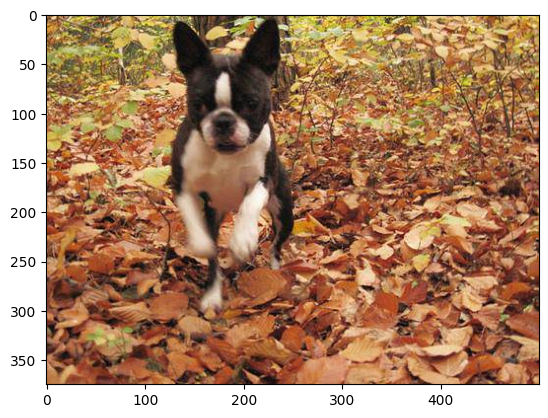

In [90]:
print(f"This is an example of an image:\n{plt.imshow(plt.imread('data/dogs/train/000bec180eb18c7604dcecc8fe0dba07.jpg'))}")

In [91]:
print(f"This is the distribution of the breeds:\n{labels['breed'].value_counts()}")

This is the distribution of the breeds:
maltese_dog           63
lakeland_terrier      60
scottish_deerhound    57
bedlington_terrier    57
saluki                55
                      ..
brabancon_griffon     30
vizsla                30
rottweiler            30
eskimo_dog            29
otterhound            27
Name: breed, Length: 120, dtype: int64


This is the distribution of the breeds:
Axes(0.125,0.11;0.775x0.77)


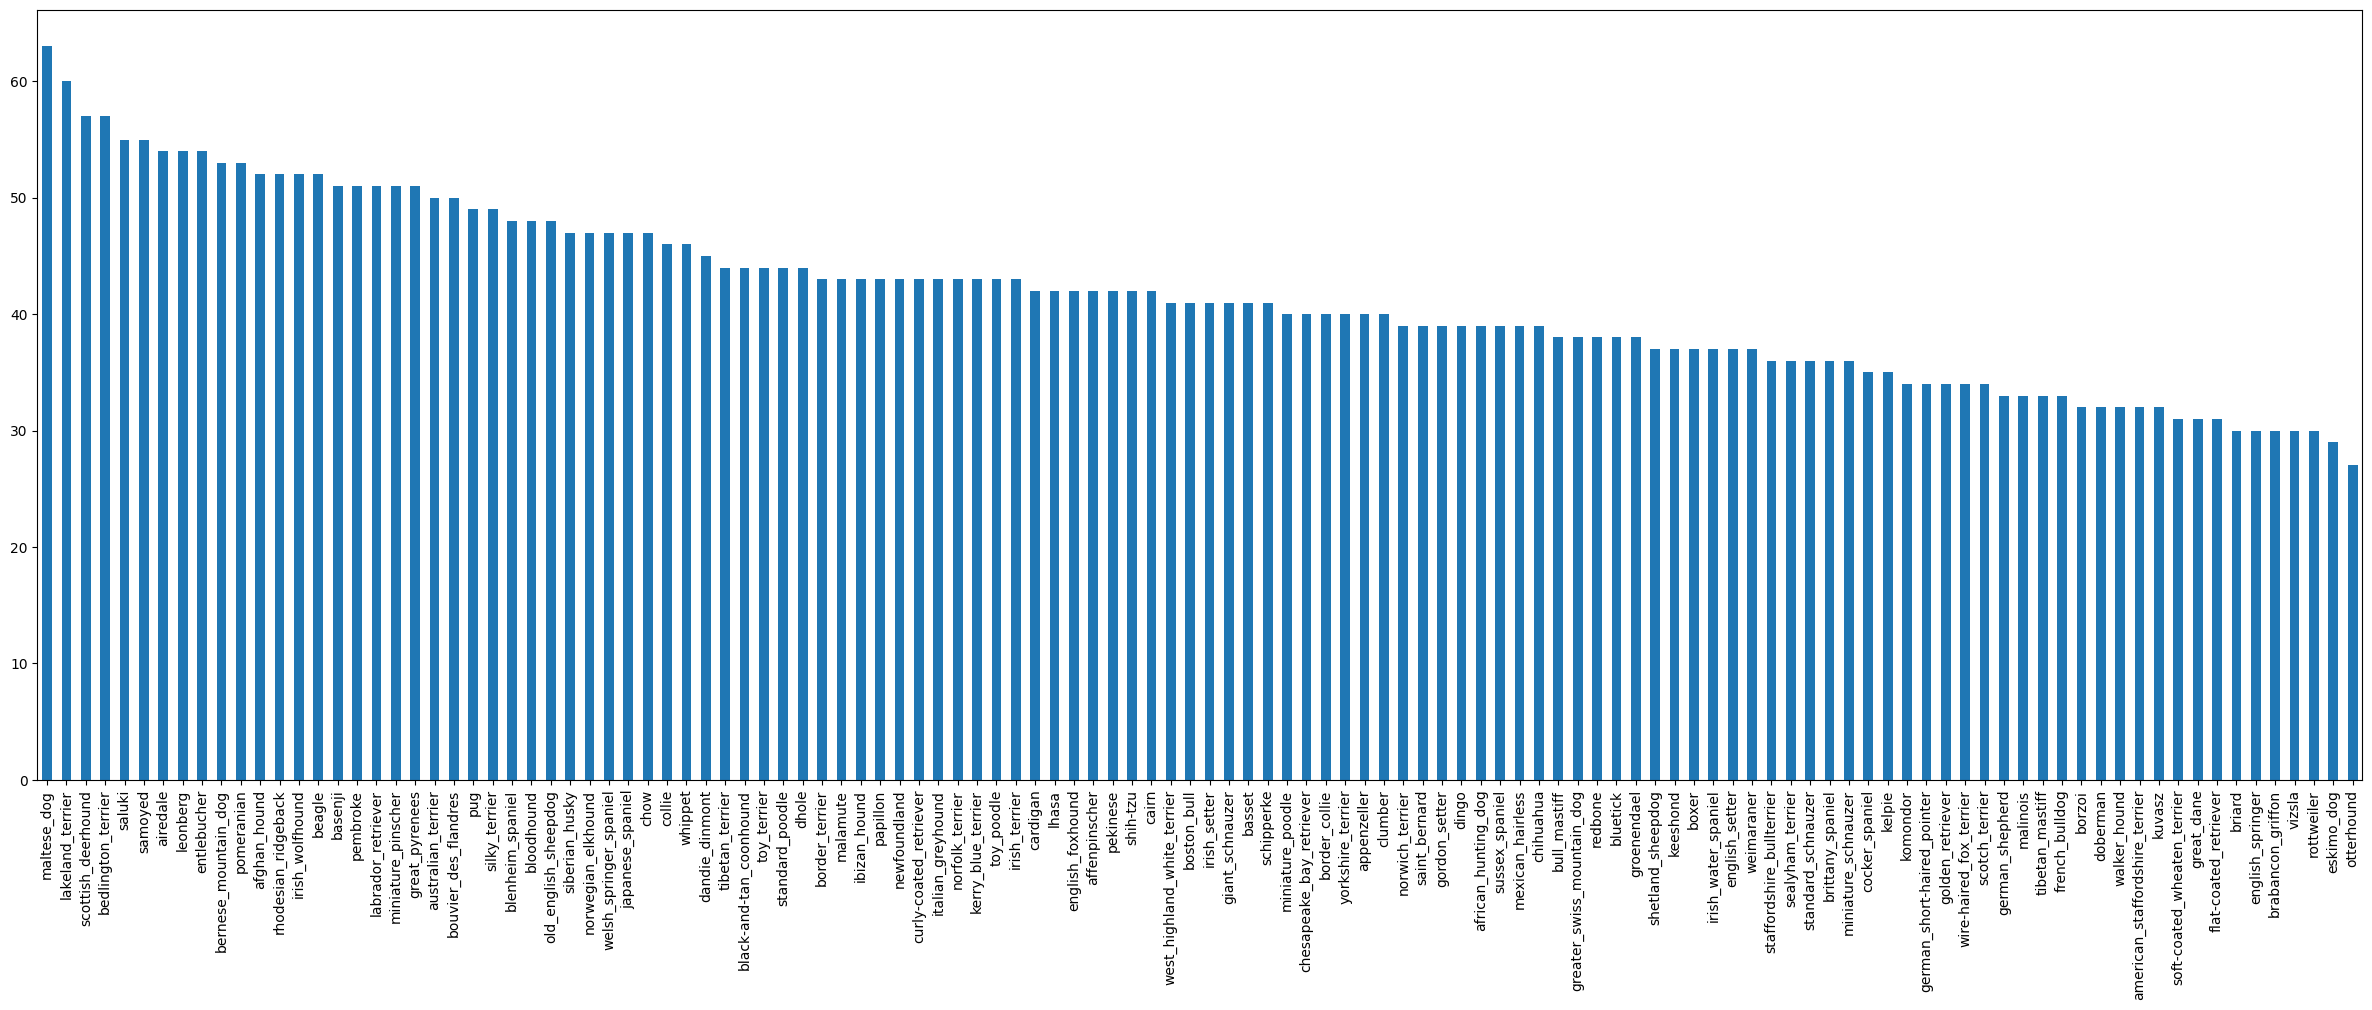

In [92]:
print(f"This is the distribution of the breeds:\n{labels['breed'].value_counts().plot(kind='bar', figsize=(30, 10))}")

### Preprocessing

In [95]:
dataset_path = 'data/dogs/train'
new_size = (128, 128)
resized_img_list = []

for i, image_id in enumerate(os.listdir(dataset_path)):
    if i == 5000:
        break
    image_path = os.path.join(dataset_path, image_id)
    img = image.load_img(image_path)
    img_array = image.img_to_array(img)
    resized_img_array = tf.image.resize(img_array, new_size)
    resized_img_array = resized_img_array / 255.0
    resized_img_list.append(resized_img_array)

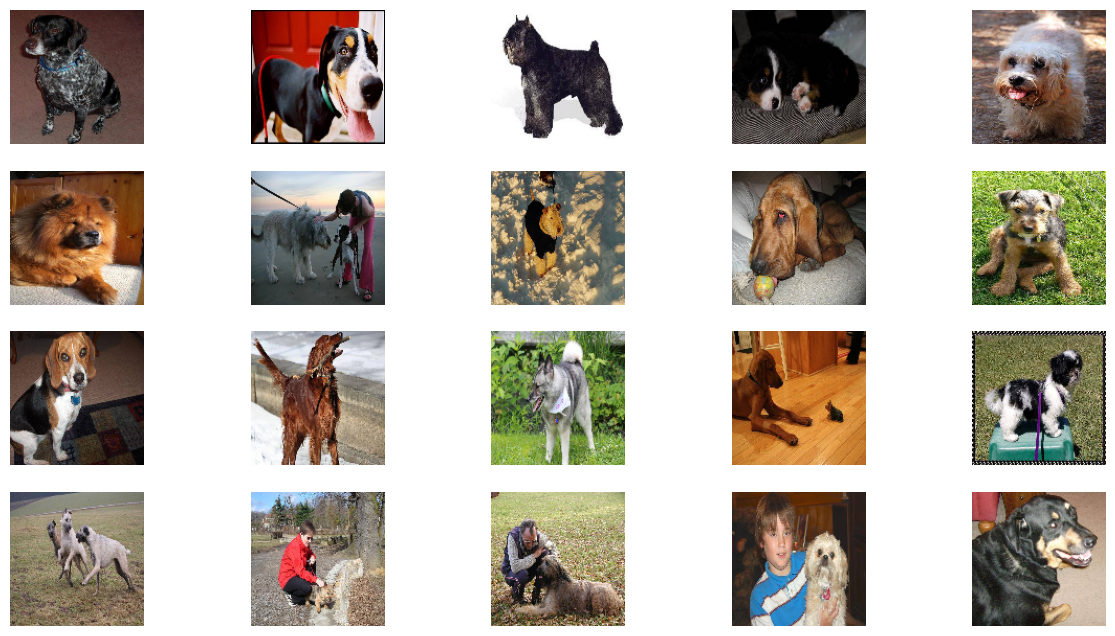

In [96]:
random_images = random.sample(resized_img_list, 20)

plt.figure(figsize=(15, 8))
for i, img_array in enumerate(random_images, 1):
    plt.subplot(4, 5, i)
    plt.imshow(img_array)
    plt.axis('off')

plt.show()

In [97]:
X = np.array(resized_img_list)
y = labels.loc[:, 'breed']
y = np.array(y)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [99]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [100]:
print(f"X_train shape: {X_train.shape}") 
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 128, 128, 3)
X_test shape: (1000, 128, 128, 3)
y_train shape: (4000,)
y_test shape: (1000,)


### Baseline Model

In [101]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DummyClassifier: {accuracy:.2f}")

Accuracy of DummyClassifier: 0.01


### Linear Model

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reshape the image arrays
X_train_flat = X_train.reshape((X_train.shape[0], -1)).astype('float16')
X_test_flat = X_test.reshape((X_test.shape[0], -1)).astype('float16')

# Create and fit Logistic Regression model
logistic_regression = LogisticRegression(max_iter=100)
logistic_regression.fit(X_train_flat, y_train)

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_flat)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression: {accuracy:.4f}")

Accuracy of Logistic Regression: 0.0260


### CNN

In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(128, 128, 3))
        self.maxpool1 = layers.MaxPooling2D((2,2))
        self.conv2 = layers.Conv2D(32, (3,3), padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D((2,2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(120, activation='softmax')  # Output layer with 10 classes and softmax activation

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Create an instance of the CNN model
model = CNN()

# Display the model summary
model.build((None, 128, 128, 3))
model.summary()


Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           multiple                  448       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  209721

In [106]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
results = model.fit(X_train, y_train, epochs=10)

### Pretrained CNN